# Robustness metric and classifier

FI = feature importance
FS = Feature selection
FG = faking good
FB = faking bad

## Prof question and thoughts

1) As regards to the importance of the features (items of the tests). After feature selection, Do diverse ML models with equal accuracy index different items as more important? (in discriminating Honest vs dishonest responses)

	ATTENTION: take note that in some datasets the Dishonest is fake-good ad in others i fake-bad.
Is there a difference in response to question n. 1 in relation to fake-good/Fake bad?


2) Does the response to question 1  change according to the dataset?


3) Which is the accuracy  in classification that is achieved using only the best 20% of the items?
Which is the amount of shrinkage with respect to the original test?  (e.g. with the full test of 100 Random forest lands an accuracy of 92% with the best 20 items the accuracy drops to 88%)
 If you take the best 20% of the items of a given test,  which is the concordance between classifiers in spotting the 20% best items? (e.g. in a test of 100 items only 10 among the best 20 are the same for different classifiers ; SVM Random Forest, knn etc.). You may use the rank order correlation


4) Are model agnostic feature selection (e.g. permutation importance or PCA) procedures better than model dependent


5) Are psychometric inspired items selection better than model based item selection?
Psychometric inspired item selection are usually based on PCA or factor analysis. With the best items selected on the basis of factor loadings.


6) Comments

Idee:
	- all'inizio fare una feature selection preventiva togliendo già variabili che sembrano colineari
	- exploratory analysis dataset and use one with good dimensionality, obv the lower, the more the variance
  	- Faking good / Faking bad difference (statistics on features importance)
  	- Given FG&FB, is FG = (1 - FB), can a classifier trained on FG predict |1-FB|
	- Given FG&FG/FB&FB, is FX_1 = FX_2... ie, can a classifier trained on FX1 predict FX2
	- if one of previous 2 yes: merge dataset to get more data to train on (more data >> better data?)
	- non rimuovere feature ma fare plot feature vs GINI/Accuracy e poi lasciare chi usa il modello a scegliere il trade off
	- feature selection usando la FI sui modelli dell'ensemble o su criteri separati
	- mettiamo gli AE in qualche modo alla fine, però magari solo su dataset grandi, giusto per mostrare che se usiamo model agnostic feature importance techniques possiamo stimare anche la la FI e i risultati sono una bolba (forse)


## Dataset
- Short DT: 2 dataset faking good (27 features x ~400 osservazioni)
- PRMQ: 1 dataset faking bad (16 feature x 1400 osservazioni)
- PCL: 1 dataset faking bad (20 feature x 400 osservazioni)
- NAQ: 1 dataset faking bad (21 feature x 800 osservazioni)
- GAD: 1 dataset faking bad (16 feature x 1100 osservazioni)
- PID: 1 dataset faking bad (220 feature x 400 osservazioni)
- Short PID: 1 dataset faking bad (25 feature x 1100 osservazioni)
- PRFQ: 1 dataset faking good (18 feature x 678 osservazioni)
- IESR: 1 dataset faking bad (22 feature x 378 osservazioni)
- NEO PI: 1 dataset faking good (30 feature x 80000 osservazioni)
- DDDT: 1 dataset faking good (15 feature x 1000 osservazioni)
- IADQ: 1 dataset faking bad (9 feature x 450 osservazioni)
- BF: 3 dataset faking good (10 feature x ~230 osservazioni)

## Intro

Algoritmo:
1. partire con un modello decente (ensemble/stacking? di un tot di modelli)
2. mix Gini index e accuracy
	a. se migliora (threshold) vai a 6
	b. continua
3. FI con qualche tecnica model agnostic (permutation imp, leave one cov out) \[+ modelli unsupervised (PCA...)\]
4. FS (elimina la più inutile)
5. riparti da 1
6. chiedi a Sara cosa vuol dire quello che ne è uscito

IMO, dovremmo anche spiegare magari nel ppt le tecniche usate, e perchè tipo permutation importance fa cagare, così almeno sembra che abbiamo idea di cosa stiamo facendo

## Import data

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score
from tqdm import trange

In [2]:
N_CV = 5

In [3]:
dataset = pd.read_csv("1shortDT//DT_df_CC.csv")
#dataset2 = pd.read_csv("1shortDT//DT_df_JI.csv", sep = ";")

In [4]:
data = np.array(dataset)

Assumption: the variables are monotonic wrt the response, so no "to categorical" is needed

In [5]:
X = data[:,:-1].astype(float) # StandardScaler().fit_transform(data[:,:-1].astype(float))
y = np.zeros(data.shape[0])
y[data[:,-1] == "H"] = 1

## Exploratory analysis

The more separated they are, the simpler is the task, as for example a Naybe bayesian yould capture the difference easily since assumes independence in the variables

### Features marginal distributions

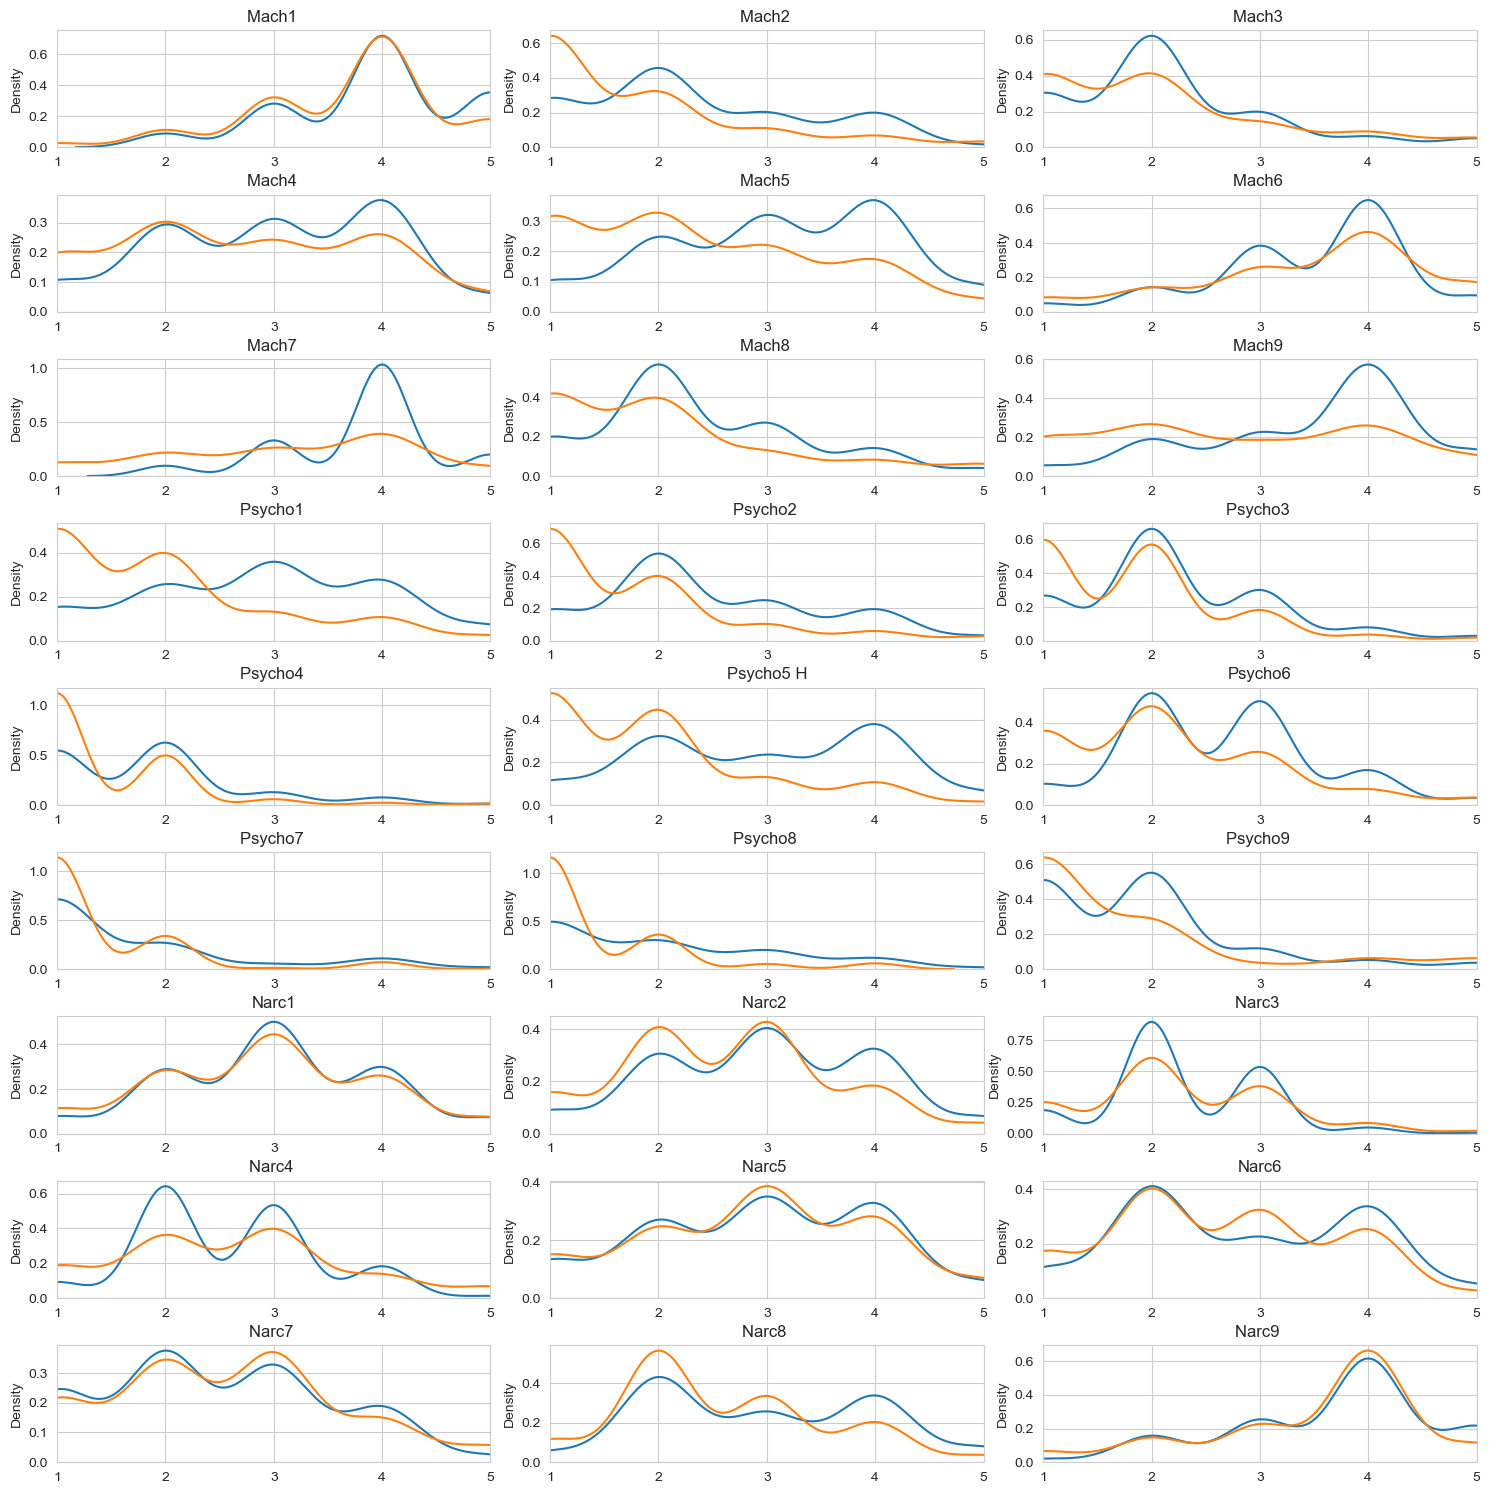

In [6]:
import seaborn as sns

fig, axs = plt.subplots(9,3, figsize=(15,15))
fig.tight_layout(pad=1.5)
for i, (ax, label_name) in enumerate(zip(axs.flatten(), dataset.columns[:-1])):
	sns.kdeplot(X[np.where(y == 1)][:,i], ax=ax)
	sns.kdeplot(X[np.where(y == 0)][:,i], ax=ax)
	ax.set_xlim(1,5)
	ax.set_xticks(range(1,6))
	ax.set_title(label_name)

### Features mean and std

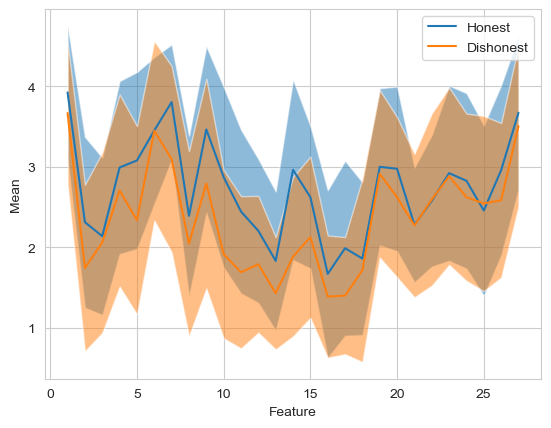

In [7]:
m1 = X[y==1].mean(axis=0)
m0 = X[y==0].mean(axis=0)
e1 = X[y==1].std(axis=0)
e0 = X[y==0].std(axis=0)
plt.fill_between(range(1, X.shape[-1]+1), m1-e1, m1+e1, alpha=0.5, label="_nolegend_")
plt.plot(range(1, X.shape[-1]+1), m1)

plt.fill_between(range(1, X.shape[-1]+1), m0-e0, m0+e0, alpha=0.5, label="_nolegend_")
plt.plot(range(1, X.shape[-1]+1), m0)

plt.ylabel("Mean")
plt.xlabel("Feature")
plt.legend(["Honest", "Dishonest"])

## FS with model dependent

In [8]:
# with model-dependent feature importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

# ensemble
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier

In [9]:
# take feature importance and transform them to distribution (positive and sum to 1)
def to_distribution(values):
	values = np.abs(values)
	return values / np.sum(values) if np.sum(values) > 0 else np.array([1])

In [10]:
random_forest = RandomForestClassifier(random_state=0).fit(X,y)
logistic_regression = LogisticRegression(random_state=0).fit(X,y)
gradient_boosting = GradientBoostingClassifier(random_state=0).fit(X,y)
svm = SVC(kernel = "linear",random_state=0).fit(X,y)

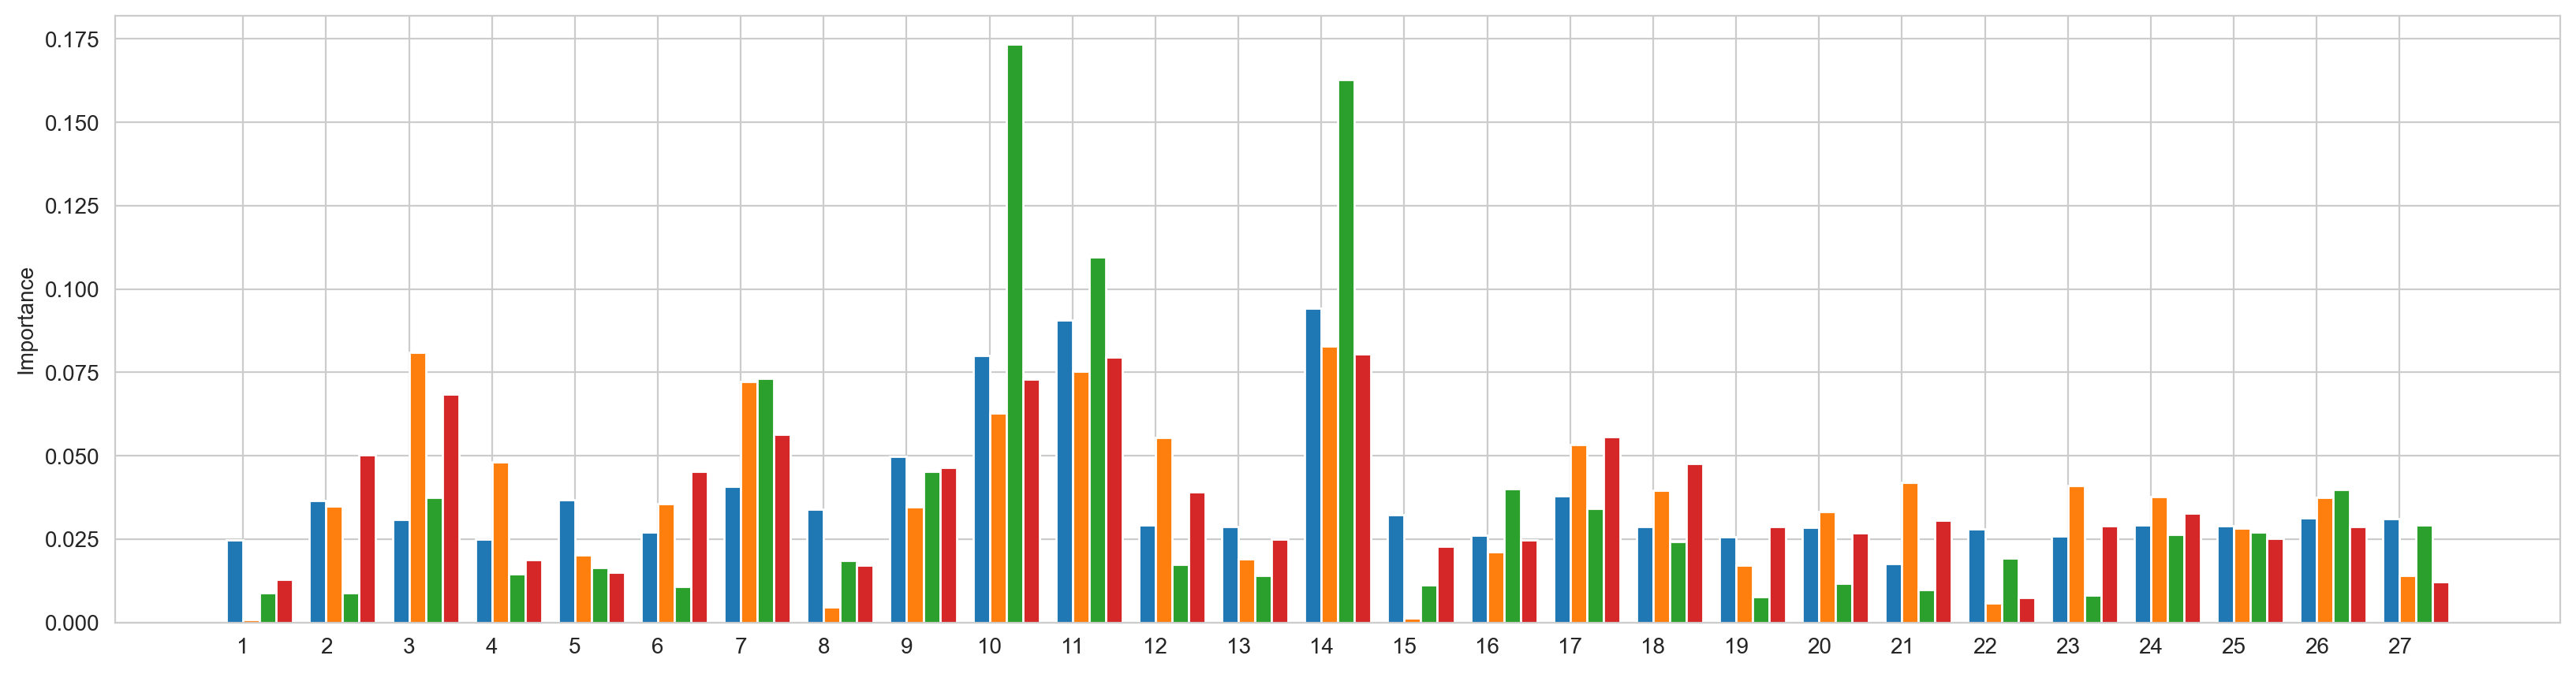

In [11]:
x_bar = np.arange(1, X.shape[-1]+1)
width = .2
plt.figure(dpi=200, figsize=(20,5))
plt.bar(x_bar, to_distribution(random_forest.feature_importances_), width=width)
plt.bar(x_bar+width, to_distribution(logistic_regression.coef_.squeeze()), width=width)
plt.bar(x_bar+width*2, to_distribution(gradient_boosting.feature_importances_), width=width)
plt.bar(x_bar+width*3, to_distribution(svm.coef_.squeeze()), width=width)
plt.ylabel("Importance")
_ = plt.xticks(x_bar + width / 2, x_bar)

Accuracy using all the features:

In [12]:
print(f"""
Accuracies:
Random Forest: {(cross_val_score(random_forest, X, y, cv=N_CV).mean()*100).round(2)}%
Logistic Regression: {(cross_val_score(logistic_regression, X, y, cv=N_CV).mean()*100).round(2)}%
Gradient Boosting: {(cross_val_score(gradient_boosting, X, y, cv=N_CV).mean()*100).round(2)}%
SVC: {(cross_val_score(svm, X, y, cv=N_CV).mean()*100).round(2)}%
""")


Accuracies:
Random Forest: 78.85%
Logistic Regression: 75.31%
Gradient Boosting: 78.84%
SVC: 76.57%



Accuracy using only top 20% specific for each model

In [13]:
random_forest_top_20_features = np.argsort(to_distribution(random_forest.feature_importances_))[::-1][:int(X.shape[-1] * .2)]
logistic_regression_top_20_features = np.argsort(to_distribution(logistic_regression.coef_.squeeze()))[::-1][:int(X.shape[-1] * .2)]
gradient_boosting_top_20_features = np.argsort(to_distribution(gradient_boosting.feature_importances_))[::-1][:int(X.shape[-1] * .2)]
svm_top_20_features = np.argsort(to_distribution(svm.coef_.squeeze()))[::-1][:int(X.shape[-1] * .2)]

print(f"""
Accuracies:
Random Forest: {(cross_val_score(random_forest, X[:,random_forest_top_20_features], y, cv=N_CV).mean()*100).round(2)}%
Logistic Regression: {(cross_val_score(logistic_regression, X[:,logistic_regression_top_20_features], y, cv=N_CV).mean()*100).round(2)}%
Gradient Boosting: {(cross_val_score(gradient_boosting, X[:,gradient_boosting_top_20_features], y, cv=N_CV).mean()*100).round(2)}%
SVC: {(cross_val_score(svm, X[:,svm_top_20_features], y, cv=N_CV).mean()*100).round(2)}%
""")


Accuracies:
Random Forest: 74.27%
Logistic Regression: 75.31%
Gradient Boosting: 76.55%
SVC: 74.89%



taking top 20%, which is the amount of concordance between them:

In [14]:
np.array((random_forest_top_20_features, logistic_regression_top_20_features, gradient_boosting_top_20_features, svm_top_20_features))

array([[13, 10,  9,  8,  6],
       [13,  2, 10,  6,  9],
       [ 9, 13, 10,  6,  8],
       [13, 10,  9,  2,  6]])

Change in accuracy considering only top N features ordered by importance wrt each model

In [15]:
random_forest_sorted_features = np.argsort(to_distribution(random_forest.feature_importances_)).squeeze()
logistic_regression_sorted_features = np.argsort(to_distribution(logistic_regression.coef_.squeeze())).squeeze()
gradient_boosting_sorted_features = np.argsort(to_distribution(gradient_boosting.feature_importances_)).squeeze()
svm_sorted_features = np.argsort(to_distribution(svm.coef_.squeeze())).squeeze()
accuracies_filtered_singularly = []
X_filtered_rf = np.copy(X)
X_filtered_lg = np.copy(X)
X_filtered_svm = np.copy(X)
X_filtered_gb = np.copy(X)
for i in trange(0, X.shape[-1]):

	# find accuracy
	accuracies_filtered_singularly.append([
		(cross_val_score(random_forest, X_filtered_rf, y, cv=N_CV, n_jobs=-1).mean()*100).round(2),
		(cross_val_score(logistic_regression, X_filtered_lg, y, cv=N_CV, n_jobs=-1).mean()*100).round(2),
		(cross_val_score(gradient_boosting, X_filtered_gb, y, cv=N_CV, n_jobs=-1).mean()*100).round(2),
		(cross_val_score(svm, X_filtered_svm, y, cv=N_CV, n_jobs=-1).mean()*100).round(2),
	])

	# train to get feature importance
	random_forest.fit(X_filtered_rf, y)
	logistic_regression.fit(X_filtered_lg, y)
	gradient_boosting.fit(X_filtered_gb, y)
	svm.fit(X_filtered_svm, y)

	# from feature importance to distribution
	random_forest_feature_importance = to_distribution(random_forest.feature_importances_)
	logistic_regression_feature_importance = to_distribution(logistic_regression.coef_.squeeze())
	gradient_boosting_feature_importance = to_distribution(gradient_boosting.feature_importances_)
	svm_feature_importance = to_distribution(svm.coef_.squeeze())

 	# remove the least important feature for each model
	X_filtered_rf = X_filtered_rf[:, np.argsort(random_forest_feature_importance)[::-1][:-1]]
	X_filtered_lg = X_filtered_lg[:, np.argsort(logistic_regression_feature_importance)[::-1][:-1]]
	X_filtered_gb = X_filtered_gb[:, np.argsort(gradient_boosting_feature_importance)[::-1][:-1]]
	X_filtered_svm = X_filtered_svm[:, np.argsort(svm_feature_importance)[::-1][:-1]]


100%|██████████| 27/27 [00:08<00:00,  3.33it/s]


Text(0, 0.5, 'Accuracy')

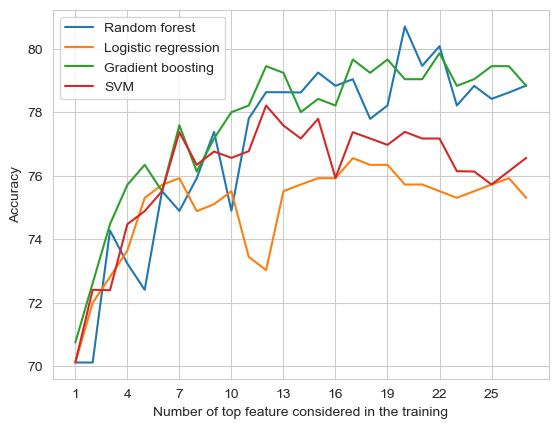

In [16]:
plt.plot(np.arange(1, X.shape[-1]+1), accuracies_filtered_singularly[::-1])
plt.xticks(np.arange(1, X.shape[-1]+1, 3))
plt.legend(["Random forest", "Logistic regression", "Gradient boosting", "SVM"])
plt.xlabel("Number of top feature considered in the training")
plt.ylabel("Accuracy")

### Feature elimination based on aggregate importance

In [63]:
to_consider = np.arange(0, X.shape[-1])
accuracies_filtered_together = []
X_filtered = np.copy(X)
feature_importance = []
features_selected_at_each_step = [np.arange(0, X.shape[-1]).tolist()]
features_importance_at_each_step = []
for i in trange(X.shape[-1], 0, -1):
	accuracies_filtered_together.append([
		(cross_val_score(random_forest, X_filtered, y, cv=N_CV, n_jobs=-1).mean()*100).round(2),
		(cross_val_score(logistic_regression, X_filtered, y, cv=N_CV, n_jobs=-1).mean()*100).round(2),
		(cross_val_score(gradient_boosting, X_filtered, y, cv=N_CV, n_jobs=-1).mean()*100).round(2),
		(cross_val_score(svm, X_filtered, y, cv=N_CV, n_jobs=-1).mean()*100).round(2),
	])
	if i > 1 :
		random_forest.fit(X_filtered, y)
		logistic_regression.fit(X_filtered, y)
		gradient_boosting.fit(X_filtered, y)
		svm.fit(X_filtered, y)

		random_forest_feature_importance = to_distribution(random_forest.feature_importances_)
		logistic_regression_feature_importance = to_distribution(logistic_regression.coef_.squeeze())
		gradient_boosting_feature_importance = to_distribution(gradient_boosting.feature_importances_)
		svm_feature_importance = to_distribution(svm.coef_.squeeze())

		summed_importance = np.sum([
			random_forest_feature_importance, logistic_regression_feature_importance,
			gradient_boosting_feature_importance, svm_feature_importance
		], axis=0)

		feature_importance.append(summed_importance)
		selected_features = np.argsort(summed_importance)[::-1][:-1]
		features_selected_at_each_step.append(selected_features)
		features_importance_at_each_step.append([
			random_forest_feature_importance, logistic_regression_feature_importance,
			gradient_boosting_feature_importance, svm_feature_importance
		])

		X_filtered = X_filtered[:,selected_features]

100%|██████████| 27/27 [00:07<00:00,  3.39it/s]


calculate the Gini index

In [73]:
# fixed
gini_index_values = [np.sum(np.square(to_distribution(f))) for f in feature_importance]

try with the Spearman rank correlation

In [75]:
from scipy import stats
from itertools import combinations
avg_spearmanr = []
for fs in features_importance_at_each_step:
	temp = [stats.spearmanr(
				np.argsort(np.argsort(fs[c[0]])),
				np.argsort(np.argsort(fs[c[1]]))
			).correlation
			for c in combinations(list(range(len(features_importance_at_each_step[0]))), 2)]
	avg_spearmanr.append(
		np.mean(temp)
	)

try with cosine distance

In [76]:
avg_cosine = []
for fs in features_importance_at_each_step:
	temp = [np.dot(fs[c[0]], fs[c[1]])/(np.linalg.norm(fs[c[0]])*np.linalg.norm(fs[c[1]]))
			for c in combinations(list(range(len(features_importance_at_each_step[0]))), 2)]
	avg_cosine.append(
		np.mean(temp)
	)

try with KL-Div (mutual information)

In [77]:
avg_kl = []
def KL(a, b):
	a = np.asarray(a, dtype=float)
	b = np.asarray(b, dtype=float)
	return np.sum(np.where(a != 0, a * np.log(a / b), 0))

for fs in features_importance_at_each_step:
	fs = to_distribution(fs)
	temp = [KL(fs[c[0]],fs[c[1]])
			for c in combinations(list(range(len(features_importance_at_each_step[0]))), 2)]
	avg_kl.append(
		np.mean(temp)
	)

try with L2 distance

In [78]:
avg_L2 = []
for fs in features_importance_at_each_step:
	temp = [np.sum(np.square(np.subtract(fs[c[0]],fs[c[1]])))
			for c in combinations(list(range(len(features_importance_at_each_step[0]))), 2)]
	avg_L2.append(
		np.mean(temp)
	)

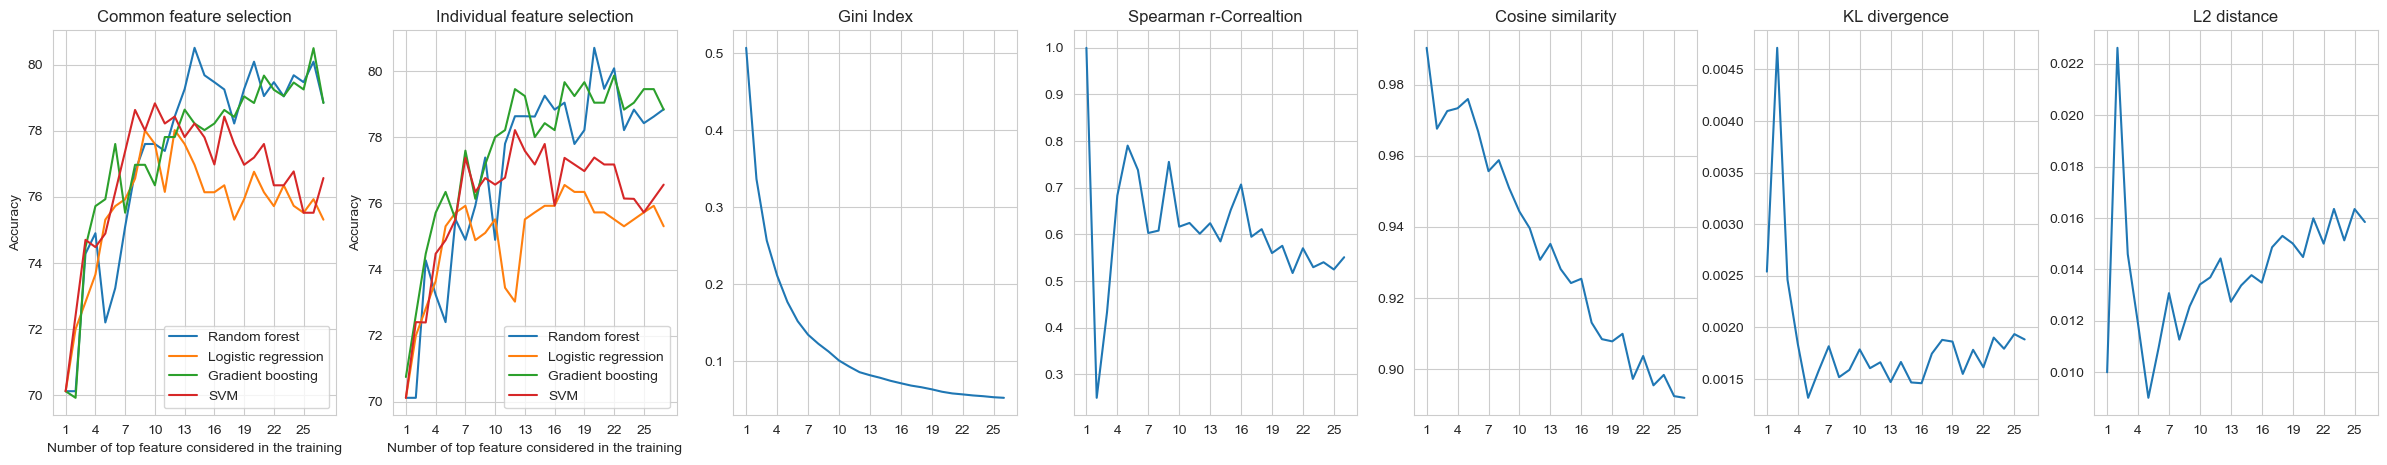

In [82]:
_, axs = plt.subplots(1, 7, figsize=(30,5))
axs[0].set_title("Common feature selection")
axs[0].plot(np.arange(1, X.shape[-1]+1), accuracies_filtered_together[::-1])
axs[0].set_xticks(np.arange(1, X.shape[-1]+1, 3))
axs[0].legend(["Random forest", "Logistic regression", "Gradient boosting", "SVM"])
axs[0].set_xlabel("Number of top feature considered in the training")
axs[0].set_ylabel("Accuracy")

axs[1].set_title("Individual feature selection")
axs[1].plot(np.arange(1, X.shape[-1]+1), accuracies_filtered_singularly[::-1])
axs[1].set_xticks(np.arange(1, X.shape[-1]+1, 3))
axs[1].legend(["Random forest", "Logistic regression", "Gradient boosting", "SVM"])
axs[1].set_xlabel("Number of top feature considered in the training")
axs[1].set_ylabel("Accuracy")

axs[2].set_title("Gini Index")
axs[2].plot(np.arange(1, X.shape[-1]), np.array(gini_index_values[::-1]))
_ = axs[2].set_xticks(np.arange(1, X.shape[-1]+1, 3))

axs[3].set_title("Spearman r-Correaltion")
axs[3].plot(np.arange(1, X.shape[-1]), avg_spearmanr[::-1])
_ = axs[3].set_xticks(np.arange(1, X.shape[-1]+1, 3))

axs[4].set_title("Cosine similarity")
axs[4].plot(np.arange(1, X.shape[-1]), avg_cosine[::-1])
_ = axs[4].set_xticks(np.arange(1, X.shape[-1]+1, 3))


axs[5].set_title("KL divergence")
axs[5].plot(np.arange(1, X.shape[-1]), np.array(avg_kl[::-1])/np.arange(1,27))
_ = axs[5].set_xticks(np.arange(1, X.shape[-1]+1, 3))


axs[6].set_title("L2 distance")
axs[6].plot(np.arange(1, X.shape[-1]), avg_L2[::-1])
_ = axs[6].set_xticks(np.arange(1, X.shape[-1]+1, 3))

$$
Index = \frac{1}{n \choose 2} \sum_{(r_0, r_1) \subset R} Index(r_0, r_1)
$$


### Using an Voting ensamble

In [24]:
voting_ensemble = VotingClassifier([
	('rf', random_forest),
	('lr', logistic_regression),
	('gb', gradient_boosting)
])

In [25]:
accuracies_voting_ensemble = []
for features in features_selected_at_each_step:
	accuracies_voting_ensemble.append((cross_val_score(voting_ensemble, X[:,features], y, cv=N_CV, n_jobs=-1).mean()*100).round(2))

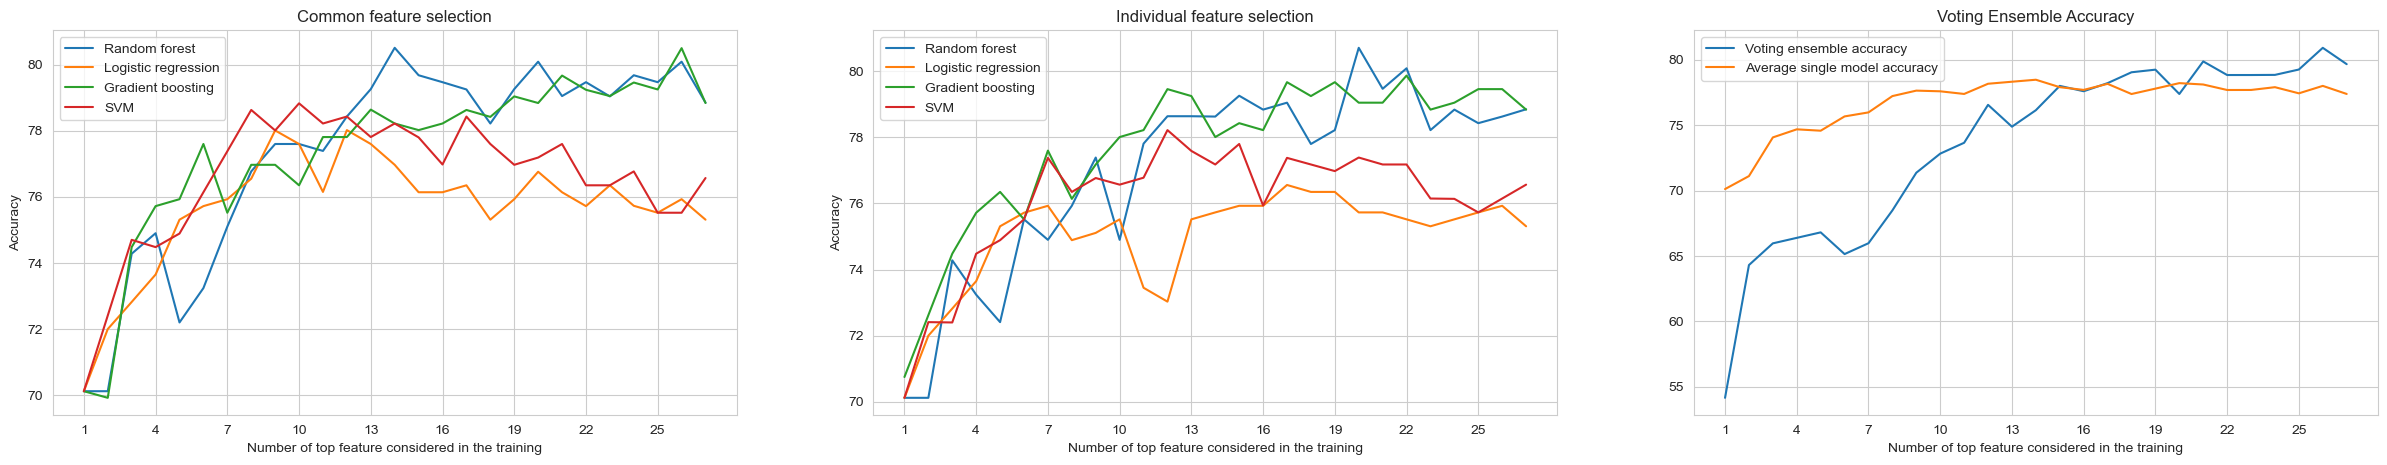

In [26]:
_, axs = plt.subplots(1, 3, figsize=(30,5))
axs[0].set_title("Common feature selection")
axs[0].plot(np.arange(1, X.shape[-1]+1), accuracies_filtered_together[::-1])
axs[0].set_xticks(np.arange(1, X.shape[-1]+1, 3))
axs[0].legend(["Random forest", "Logistic regression", "Gradient boosting", "SVM"])
axs[0].set_xlabel("Number of top feature considered in the training")
axs[0].set_ylabel("Accuracy")

axs[1].set_title("Individual feature selection")
axs[1].plot(np.arange(1, X.shape[-1]+1), accuracies_filtered_singularly[::-1])
axs[1].set_xticks(np.arange(1, X.shape[-1]+1, 3))
axs[1].legend(["Random forest", "Logistic regression", "Gradient boosting", "SVM"])
axs[1].set_xlabel("Number of top feature considered in the training")
axs[1].set_ylabel("Accuracy")

axs[2].set_title("Voting Ensemble Accuracy")
axs[2].plot(np.arange(1, X.shape[-1]+1), accuracies_voting_ensemble[::-1])
axs[2].plot(np.arange(1, X.shape[-1]+1), np.mean(accuracies_filtered_together[::-1], axis=-1))
axs[2].legend(["Voting ensemble accuracy","Average single model accuracy"])
axs[2].set_xlabel("Number of top feature considered in the training")
_ = axs[2].set_xticks(np.arange(1, X.shape[-1]+1, 3))


### Using Stacking Ensemble (meta-learning)

In [27]:
stacking_ensemble = StackingClassifier(estimators=[
	('rf', RandomForestClassifier(n_estimators=100)),
	('gb', gradient_boosting),
], final_estimator=logistic_regression)

In [28]:
accuracies_stacking_ensemble = []
for features in features_selected_at_each_step:
	accuracies_stacking_ensemble.append((cross_val_score(stacking_ensemble, X[:,features], y, cv=N_CV, n_jobs=-1).mean()*100).round(2))

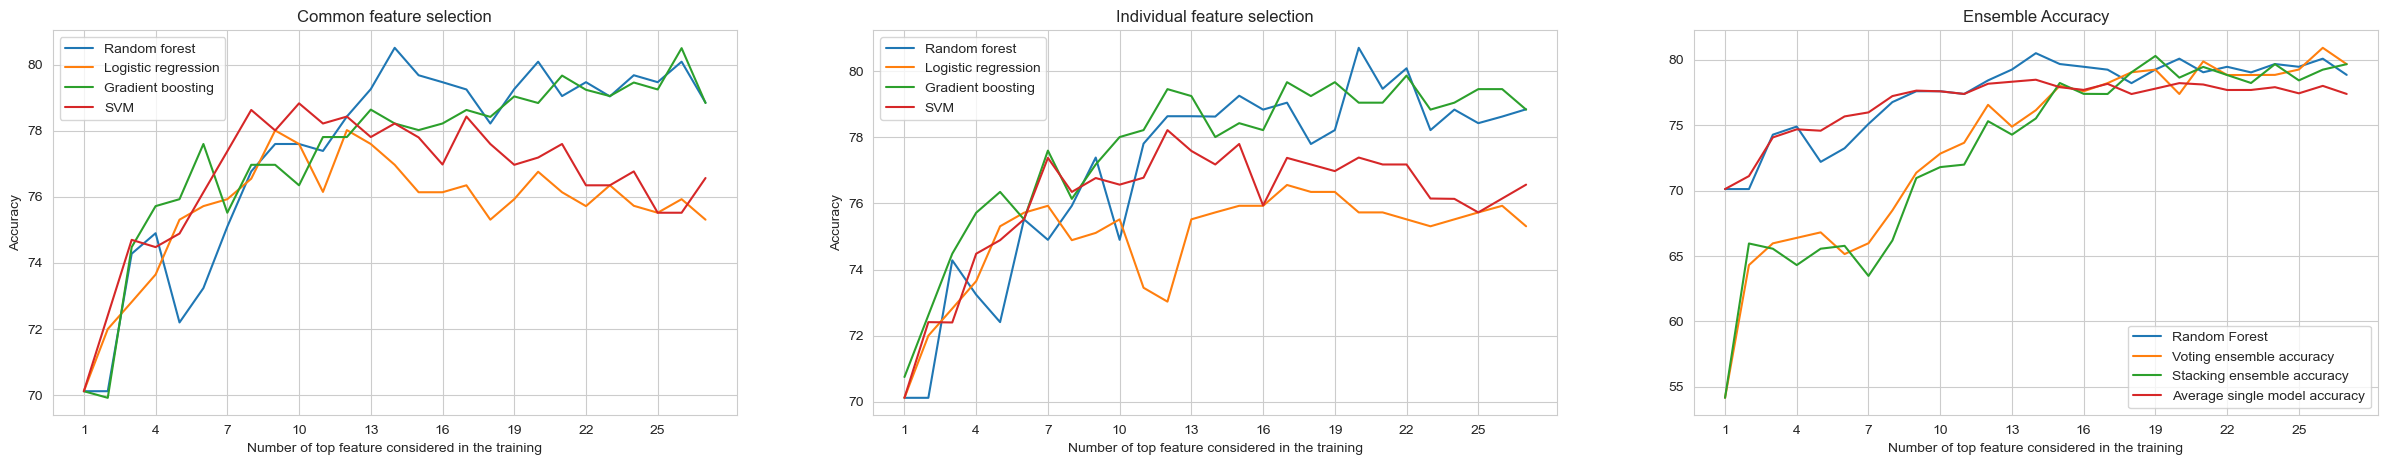

In [29]:
_, axs = plt.subplots(1, 3, figsize=(30,5))
axs[0].set_title("Common feature selection")
axs[0].plot(np.arange(1, X.shape[-1]+1), accuracies_filtered_together[::-1])
axs[0].set_xticks(np.arange(1, X.shape[-1]+1, 3))
axs[0].legend(["Random forest", "Logistic regression", "Gradient boosting", "SVM"])
axs[0].set_xlabel("Number of top feature considered in the training")
axs[0].set_ylabel("Accuracy")

axs[1].set_title("Individual feature selection")
axs[1].plot(np.arange(1, X.shape[-1]+1), accuracies_filtered_singularly[::-1])
axs[1].set_xticks(np.arange(1, X.shape[-1]+1, 3))
axs[1].legend(["Random forest", "Logistic regression", "Gradient boosting", "SVM"])
axs[1].set_xlabel("Number of top feature considered in the training")
axs[1].set_ylabel("Accuracy")

axs[2].set_title("Ensemble Accuracy")
axs[2].plot(np.arange(1, X.shape[-1]+1), np.array(accuracies_filtered_together[::-1])[:,0])
axs[2].plot(np.arange(1, X.shape[-1]+1), accuracies_voting_ensemble[::-1])
axs[2].plot(np.arange(1, X.shape[-1]+1), accuracies_stacking_ensemble[::-1])
axs[2].plot(np.arange(1, X.shape[-1]+1), np.mean(accuracies_filtered_together[::-1], axis=-1))
axs[2].legend(["Random Forest", "Voting ensemble accuracy","Stacking ensemble accuracy","Average single model accuracy"])
axs[2].set_xlabel("Number of top feature considered in the training")
_ = axs[2].set_xticks(np.arange(1, X.shape[-1]+1, 3))


## FS with model independent with classifiers

here:
  	- permutation importance
  	- partial dependence
  	- leave one covariate out
  	- Information Gain

here and in the unsupervised section we can use more models as the techniques used to estimate the importance are model agnostic, so we don't need a clear estimator inside the model (reason why I just used those 4 models)

In [30]:
# Extra, per iniziare confronteremo solo quelli con la baseline di sklearn (quelli fatti nella sezione prima)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import HistGradientBoostingClassifier # categorical_features

### Permutation importance

In [31]:
random_forest = RandomForestClassifier(random_state=0).fit(X,y)
logistic_regression = LogisticRegression(random_state=0).fit(X,y)
gradient_boosting = GradientBoostingClassifier(random_state=0).fit(X,y)
svm = SVC(kernel = "linear",random_state=0).fit(X,y)

In [32]:
from sklearn.inspection import permutation_importance
PI_random_forest= permutation_importance(random_forest, X, y, n_repeats=10, random_state=0)
PI_logistic_regression= permutation_importance(logistic_regression, X, y, n_repeats=10, random_state=0)
PI_gradient_boosting= permutation_importance(gradient_boosting, X, y, n_repeats=10, random_state=0)
PI_svm=permutation_importance(svm, X, y, n_repeats=10, random_state=0)

In [33]:
PI_random_forest_importance=to_distribution(PI_random_forest.importances_mean)
PI_logistic_regression_importance=to_distribution(PI_logistic_regression.importances_mean)
PI_gradient_boosting_importance=to_distribution(PI_gradient_boosting.importances_mean)
PI_svm_importance=to_distribution(PI_svm.importances_mean)

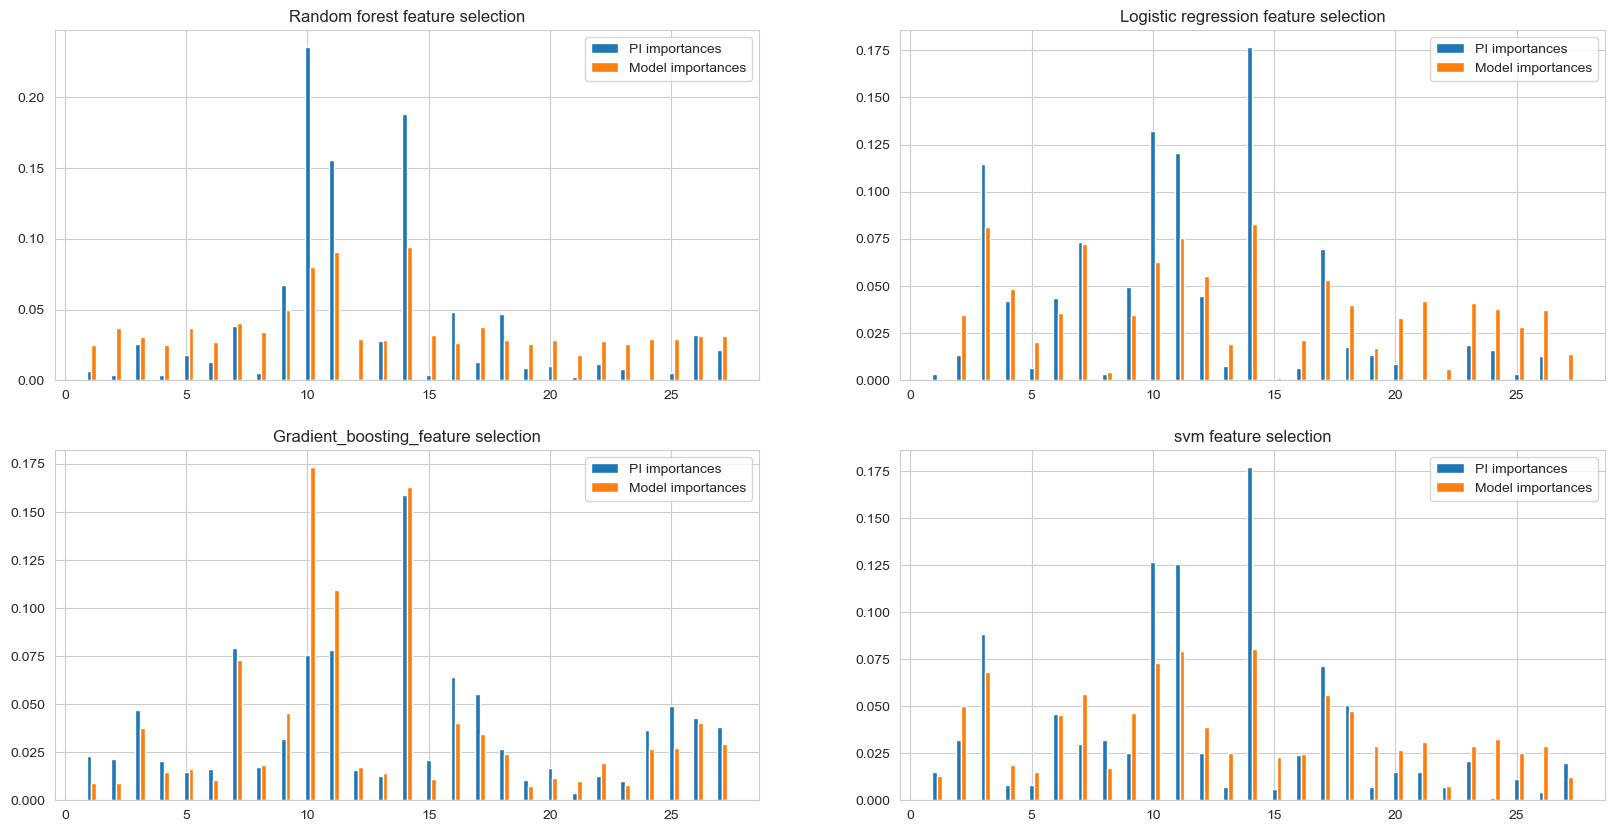

In [34]:
x_bar = np.arange(1, X.shape[-1]+1)
width = .2
_, axs = plt.subplots(2, 2, figsize=(20,10))
axs[0][0].set_title("Random forest feature selection")
axs[0][0].bar(x_bar, PI_random_forest_importance, width=width)
axs[0][0].bar(x_bar+width, to_distribution(random_forest.feature_importances_), width=width)
axs[0][0].legend(["PI importances", "Model importances"])
axs[0][1].set_title("Logistic regression feature selection")
axs[0][1].bar(x_bar, PI_logistic_regression_importance, width=width)
axs[0][1].bar(x_bar+width, to_distribution(logistic_regression.coef_.squeeze()), width=width)
axs[0][1].legend(["PI importances", "Model importances"])
axs[1][0].set_title("Gradient_boosting_feature selection")
axs[1][0].bar(x_bar, PI_gradient_boosting_importance, width=width)
axs[1][0].bar(x_bar+width, to_distribution(gradient_boosting.feature_importances_), width=width)
axs[1][0].legend(["PI importances", "Model importances"])
axs[1][1].set_title("svm feature selection")
axs[1][1].bar(x_bar, PI_svm_importance, width=width)
axs[1][1].bar(x_bar+width, to_distribution(svm.coef_.squeeze()), width=width)
axs[1][1].legend(["PI importances", "Model importances"])


In [35]:
accuracies_filtered_PI= []
X_filtered_rf = np.copy(X)
X_filtered_lr=np.copy(X)
X_filtered_gb=np.copy(X)
X_filtered_svm=np.copy(X)
for i in trange(0, X.shape[-1]):
  accuracies_filtered_PI.append([
		(cross_val_score(random_forest, X_filtered_rf, y, cv=N_CV, n_jobs=-1).mean()*100).round(2),
		(cross_val_score(logistic_regression, X_filtered_lr, y, cv=N_CV, n_jobs=-1).mean()*100).round(2),
		(cross_val_score(gradient_boosting, X_filtered_gb, y, cv=N_CV, n_jobs=-1).mean()*100).round(2),
		(cross_val_score(svm, X_filtered_svm, y, cv=N_CV, n_jobs=-1).mean()*100).round(2),
	])

  random_forest_filtered = RandomForestClassifier(random_state=0).fit(X_filtered_rf,y)
  logistic_regression_filtered=LogisticRegression(random_state=0).fit(X_filtered_lr,y)
  gradient_boosting_filtered = GradientBoostingClassifier(random_state=0).fit(X_filtered_gb,y)
  svm_filtered = SVC(kernel = "linear", random_state=0).fit(X_filtered_svm,y)

  PI_random_forest_filtered= permutation_importance(random_forest_filtered, X_filtered_rf, y, n_repeats=10, random_state=0)
  PI_logistic_regression_filtered= permutation_importance(logistic_regression_filtered, X_filtered_lr, y, n_repeats=10, random_state=0)
  PI_gradient_boosting_filtered= permutation_importance(gradient_boosting_filtered, X_filtered_gb, y, n_repeats=10, random_state=0)
  PI_svm_filtered= permutation_importance(svm_filtered, X_filtered_svm, y, n_repeats=10, random_state=0)

  PI_random_forest_filtered_feature_importance=to_distribution(PI_random_forest_filtered.importances_mean)
  PI_logistic_regression_filtered_feature_importance=to_distribution(PI_logistic_regression_filtered.importances_mean)
  PI_gradient_boosting_filtered_feature_importance=to_distribution(PI_gradient_boosting_filtered.importances_mean)
  PI_svm_filtered_feature_importance=to_distribution(PI_svm_filtered.importances_mean)

  X_filtered_rf= X_filtered_rf[:, np.argsort(PI_random_forest_filtered_feature_importance)[::-1][:-1]]
  X_filtered_lr= X_filtered_lr[:, np.argsort(PI_logistic_regression_filtered_feature_importance)[::-1][:-1]]
  X_filtered_gb= X_filtered_gb[:, np.argsort(PI_gradient_boosting_filtered_feature_importance)[::-1][:-1]]
  X_filtered_svm= X_filtered_svm[:, np.argsort(PI_svm_filtered_feature_importance)[::-1][:-1]]

100%|██████████| 27/27 [00:41<00:00,  1.56s/it]


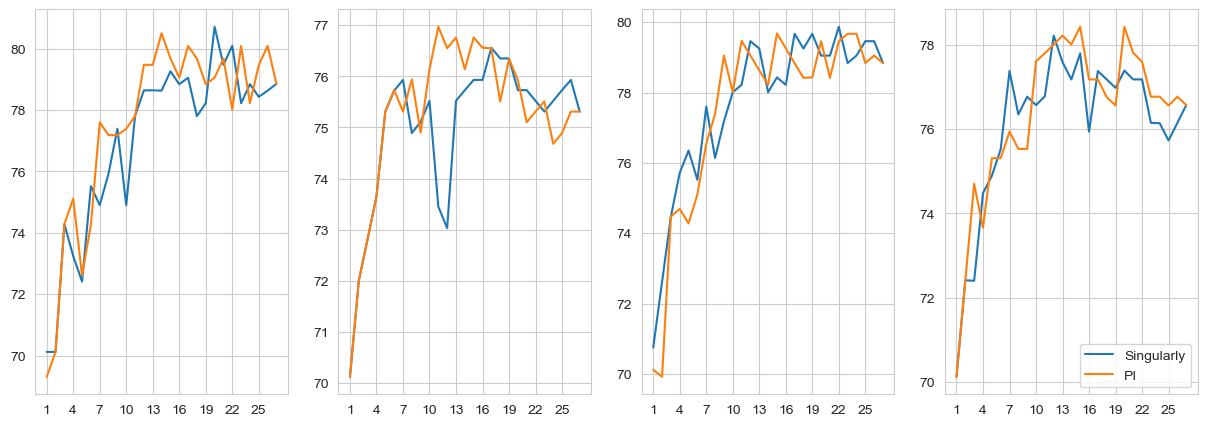

In [36]:
accuracies_filtered_singularly = np.array(accuracies_filtered_singularly)
accuracies_filtered_PI = np.array(accuracies_filtered_PI)

_, axs = plt.subplots(1, 4, figsize=(15,5))
for i in range(4):
	axs[i].plot(np.arange(1, X.shape[-1]+1), accuracies_filtered_singularly[:,i][::-1])
	axs[i].plot(np.arange(1, X.shape[-1]+1), accuracies_filtered_PI[:,i][::-1])
	axs[i].set_xticks(np.arange(1, X.shape[-1]+1, 3))
plt.legend(["Singularly", "PI"])

In [37]:
PI_random_forest_top_20_features = np.argsort(PI_random_forest_importance)[::-1][:int(X.shape[-1] * .2)]
PI_logistic_regression_top_20_features = np.argsort(PI_logistic_regression_importance)[::-1][:int(X.shape[-1] * .2)]
PI_gradient_boosting_top_20_features=np.argsort(PI_gradient_boosting_importance)[::-1][:int(X.shape[-1] * .2)]
PI_svm_top_20_features=np.argsort(PI_svm_importance)[::-1][:int(X.shape[-1] * .2)]
print(f"""
Accuracies:
Random Forest: {(accuracies_filtered_PI[-int(len(accuracies_filtered_PI) * .2)][0]).round(2)}%
Logistic Regression: {(accuracies_filtered_PI[-int(len(accuracies_filtered_PI) * .2)][1]).round(2)}%
Gradient Boosting: {(accuracies_filtered_PI[-int(len(accuracies_filtered_PI) * .2)][2]).round(2)}%
SVC: {(accuracies_filtered_PI[-int(len(accuracies_filtered_PI) * .2)][3]).round(2)}%
""")


Accuracies:
Random Forest: 72.61%
Logistic Regression: 75.31%
Gradient Boosting: 74.28%
SVC: 75.31%



In [38]:
np.array((random_forest_top_20_features, PI_random_forest_top_20_features)).squeeze()

array([[13, 10,  9,  8,  6],
       [ 9, 13, 10,  8, 15]])

In [39]:
np.array((logistic_regression_top_20_features,PI_logistic_regression_top_20_features)).squeeze()

array([[13,  2, 10,  6,  9],
       [13,  9, 10,  2,  6]])

In [40]:
np.array((gradient_boosting_top_20_features,PI_gradient_boosting_top_20_features)).squeeze()

array([[ 9, 13, 10,  6,  8],
       [13,  6, 10,  9, 15]])

In [41]:
np.array((svm_top_20_features,PI_svm_top_20_features)).squeeze()

array([[13, 10,  9,  2,  6],
       [13,  9, 10,  2, 16]])

### LOCO

In [42]:
def LOCO(model, X, y):
	res = []
	baseline = cross_val_score(model, X, y, n_jobs=-1, cv=N_CV).mean()
	for i in range(X.shape[-1]):
		loco_acc = cross_val_score(model, X[:, np.where(np.arange(0, X.shape[-1]) != i)[0]], y, n_jobs=-1, cv=N_CV).mean()
		res.append(loco_acc - baseline)
	return np.array(res)
def LOCO_scores_to_importance(res):
	res = -res
	return res - np.min(res)

CPU times: user 82 ms, sys: 10.5 ms, total: 92.5 ms
Wall time: 1.97 s


<BarContainer object of 27 artists>

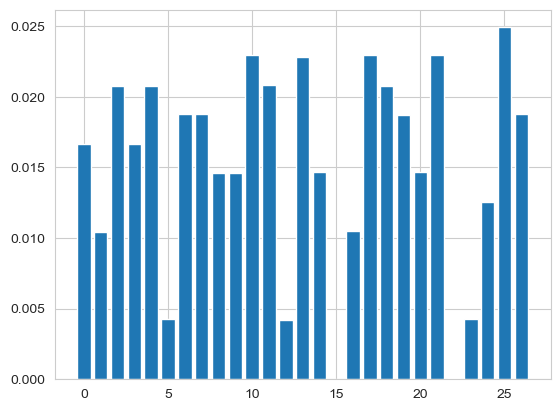

In [43]:
%%time
np.random.seed(0)
random_forest = RandomForestClassifier(random_state=0)
plt.bar(np.arange(0, X.shape[-1]) , LOCO_scores_to_importance(LOCO(random_forest, X, y)))

In [44]:
rf_lofoimportance = LOCO_scores_to_importance(LOCO(random_forest, X, y))
lr_lofoimportance = LOCO_scores_to_importance(LOCO(logistic_regression, X, y))
gb_lofoimportance = LOCO_scores_to_importance(LOCO(gradient_boosting, X, y))
svm_lofoimportance = LOCO_scores_to_importance(LOCO(svm, X, y))

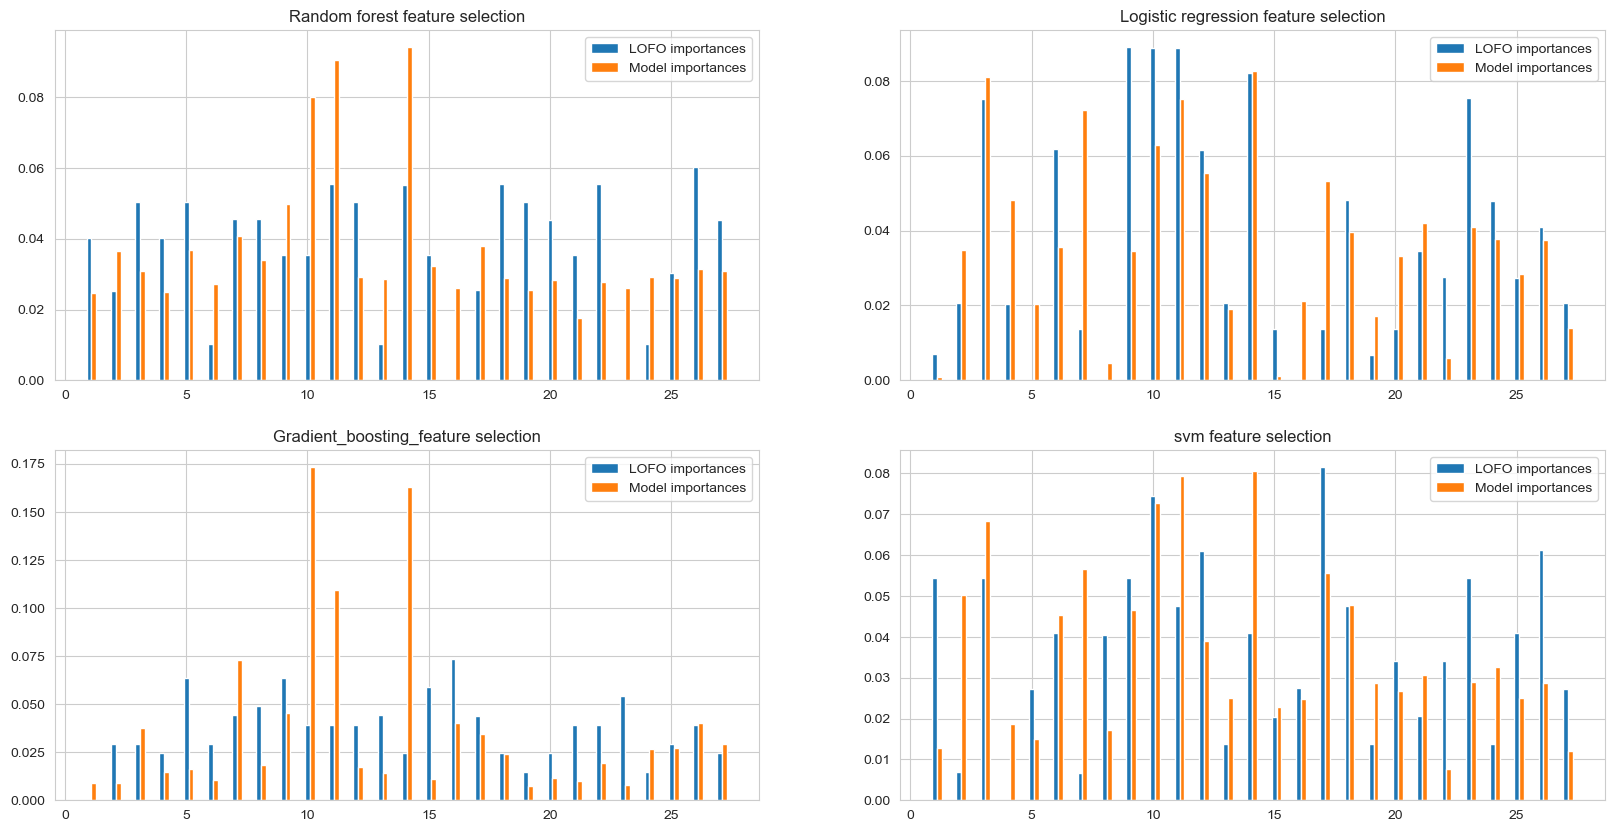

In [45]:
x_bar = np.arange(1, X.shape[-1]+1)
width = .2
_, axs = plt.subplots(2, 2, figsize=(20,10))
axs[0][0].set_title("Random forest feature selection")
axs[0][0].bar(x_bar,to_distribution(rf_lofoimportance), width=width)
random_forest.fit(X,y)
axs[0][0].bar(x_bar+width, to_distribution(random_forest.feature_importances_), width=width)
axs[0][0].legend(["LOFO importances", "Model importances"])
axs[0][1].set_title("Logistic regression feature selection")
axs[0][1].bar(x_bar, to_distribution(lr_lofoimportance), width=width)
logistic_regression.fit(X,y)
axs[0][1].bar(x_bar+width, to_distribution(logistic_regression.coef_.squeeze()), width=width)
axs[0][1].legend(["LOFO importances", "Model importances"])
axs[1][0].set_title("Gradient_boosting_feature selection")
axs[1][0].bar(x_bar, to_distribution(gb_lofoimportance), width=width)
gradient_boosting.fit(X,y)
axs[1][0].bar(x_bar+width, to_distribution(gradient_boosting.feature_importances_), width=width)
axs[1][0].legend(["LOFO importances", "Model importances"])
axs[1][1].set_title("svm feature selection")
axs[1][1].bar(x_bar, to_distribution(svm_lofoimportance), width=width)
svm.fit(X,y)
axs[1][1].bar(x_bar+width, to_distribution(svm.coef_.squeeze()), width=width)
axs[1][1].legend(["LOFO importances", "Model importances"])

In [46]:
accuracies_filtered_LOFO= []
X_filtered_rf = np.copy(X)
X_filtered_lr=np.copy(X)
X_filtered_gb=np.copy(X)
X_filtered_svm=np.copy(X)
for i in trange(0, X.shape[-1]-1):
  accuracies_filtered_LOFO.append([
		(cross_val_score(random_forest, X_filtered_rf, y, cv=N_CV, n_jobs=-1).mean()*100).round(2),
		(cross_val_score(logistic_regression, X_filtered_lr, y, cv=N_CV, n_jobs=-1).mean()*100).round(2),
		(cross_val_score(gradient_boosting, X_filtered_gb, y, cv=N_CV, n_jobs=-1).mean()*100).round(2),
		(cross_val_score(svm, X_filtered_svm, y, cv=N_CV, n_jobs=-1).mean()*100).round(2),
	])
  rf_filtered_lofo_importance = LOCO_scores_to_importance(LOCO(random_forest, X_filtered_rf, y))
  lr_filtered_lofo_importance = LOCO_scores_to_importance(LOCO(logistic_regression, X_filtered_lr, y))
  gb_filtered_lofo_importance = LOCO_scores_to_importance(LOCO(gradient_boosting, X_filtered_gb, y))
  svm_filtered_lofo_importance = LOCO_scores_to_importance(LOCO(svm, X_filtered_svm, y))

  lofo_random_forest_filtered_feature_importance = to_distribution(rf_filtered_lofo_importance)
  lofo_logistic_regression_filtered_feature_importance = to_distribution(lr_filtered_lofo_importance)
  lofo_gradient_boosting_filtered_feature_importance = to_distribution(gb_filtered_lofo_importance)
  lofo_svm_filtered_feature_importance = to_distribution(svm_filtered_lofo_importance)

  X_filtered_rf = X_filtered_rf[:, np.argsort(lofo_random_forest_filtered_feature_importance)[::-1][:-1]]
  X_filtered_lr = X_filtered_lr[:, np.argsort(lofo_logistic_regression_filtered_feature_importance)[::-1][:-1]]
  X_filtered_gb = X_filtered_gb[:, np.argsort( lofo_gradient_boosting_filtered_feature_importance)[::-1][:-1]]
  X_filtered_svm = X_filtered_svm[:, np.argsort(lofo_svm_filtered_feature_importance)[::-1][:-1]]

100%|██████████| 26/26 [00:56<00:00,  2.19s/it]


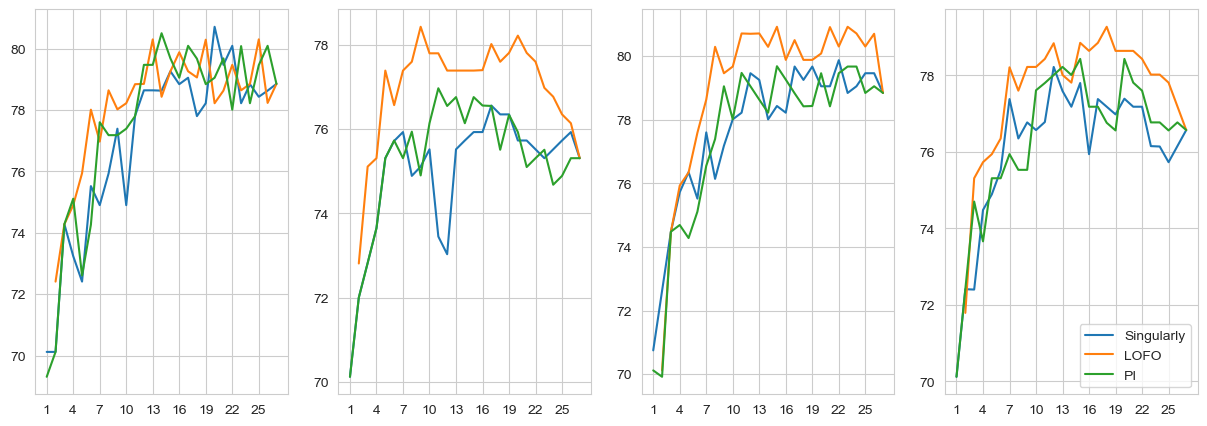

In [47]:
accuracies_filtered_singularly = np.array(accuracies_filtered_singularly)
accuracies_filtered_LOFO = np.array(accuracies_filtered_LOFO)

_, axs = plt.subplots(1, 4, figsize=(15,5))
for i in range(4):
	axs[i].plot(np.arange(1, X.shape[-1]+1), accuracies_filtered_singularly[:,i][::-1])
	axs[i].plot(np.arange(2, X.shape[-1]+1), accuracies_filtered_LOFO[:,i][::-1])
	axs[i].plot(np.arange(1, X.shape[-1]+1), accuracies_filtered_PI[:,i][::-1])
	axs[i].set_xticks(np.arange(1, X.shape[-1], 3))
plt.legend(["Singularly", "LOFO", "PI"])

In [48]:
LOFO_random_forest_top_20_features = np.argsort(rf_lofoimportance)[::-1][:int(X.shape[-1] * .2)]
LOFO_logistic_regression_top_20_features = np.argsort(lr_lofoimportance)[::-1][:int(X.shape[-1] * .2)]
LOFO_gradient_boosting_top_20_features=np.argsort(gb_lofoimportance)[::-1][:int(X.shape[-1] * .2)]
LOFO_svm_top_20_features=np.argsort(svm_lofoimportance)[::-1][:int(X.shape[-1] * .2)]
print(f"""
Accuracies:
Random Forest: {(accuracies_filtered_LOFO[-int(len(accuracies_filtered_LOFO) * .2)][0]).round(2)}%
Logistic Regression: {(accuracies_filtered_LOFO[-int(len(accuracies_filtered_LOFO) * .2)][1]).round(2)}%
Gradient Boosting: {(accuracies_filtered_LOFO[-int(len(accuracies_filtered_LOFO) * .2)][2]).round(2)}%
SVC: {(accuracies_filtered_LOFO[-int(len(accuracies_filtered_LOFO) * .2)][3]).round(2)}%
""")


Accuracies:
Random Forest: 78.01%
Logistic Regression: 76.57%
Gradient Boosting: 77.59%
SVC: 76.35%



## FS with model independent without classifiers

here:
	- PCA (allenarlo su tutto vs allenarlo solo su quelli onesti)
	- SparsePCA
	- Factor analysis
  	- Relief
  	- Mutual Information
  	- Minimum Redundancy Maximum Relevance (mRMR)
  	- tutta la roba che c'è qua https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection

In [50]:
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import SparsePCA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import FactorAnalysis

In [51]:
def calc_loadings(X, X_trans):
	loadings = np.zeros(shape = (X_trans.shape[1], X.shape[1]))
	for i in range(X_trans.shape[1]):
		for j in range(X.shape[1]):
			loadings[i,j] = np.cov(X_trans[:,i], X[:,j])[0][1]
	return loadings
def loadings_to_importance(loadings):
	return np.abs(loadings).sum(axis=0)

### PCA

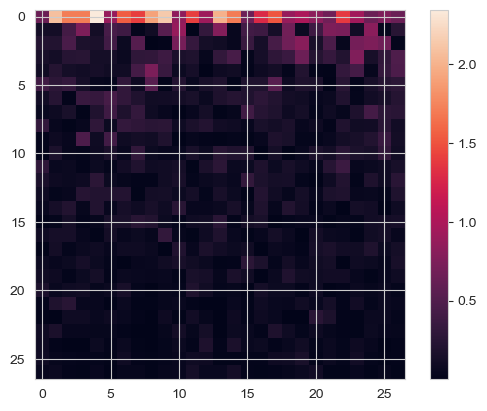

In [52]:
# PCA without limits in number of components or explained variance
pca = PCA()
# Fitting on all the data
pca.fit(X)

plt.imshow(np.abs(calc_loadings(X, pca.transform(X))))
plt.colorbar()

In [53]:
random_forest = RandomForestClassifier(random_state=0).fit(X, y)
logistic_regression = LogisticRegression(random_state=0).fit(X, y)
gradient_boosting = GradientBoostingClassifier(random_state=0).fit(X, y)
svm = SVC(kernel="linear", random_state=0).fit(X, y)
summed_importances = np.sum([
	to_distribution(random_forest.feature_importances_),
	to_distribution(logistic_regression.coef_.squeeze()),
	to_distribution(gradient_boosting.feature_importances_),
	to_distribution(svm.coef_.squeeze())
], axis=0)

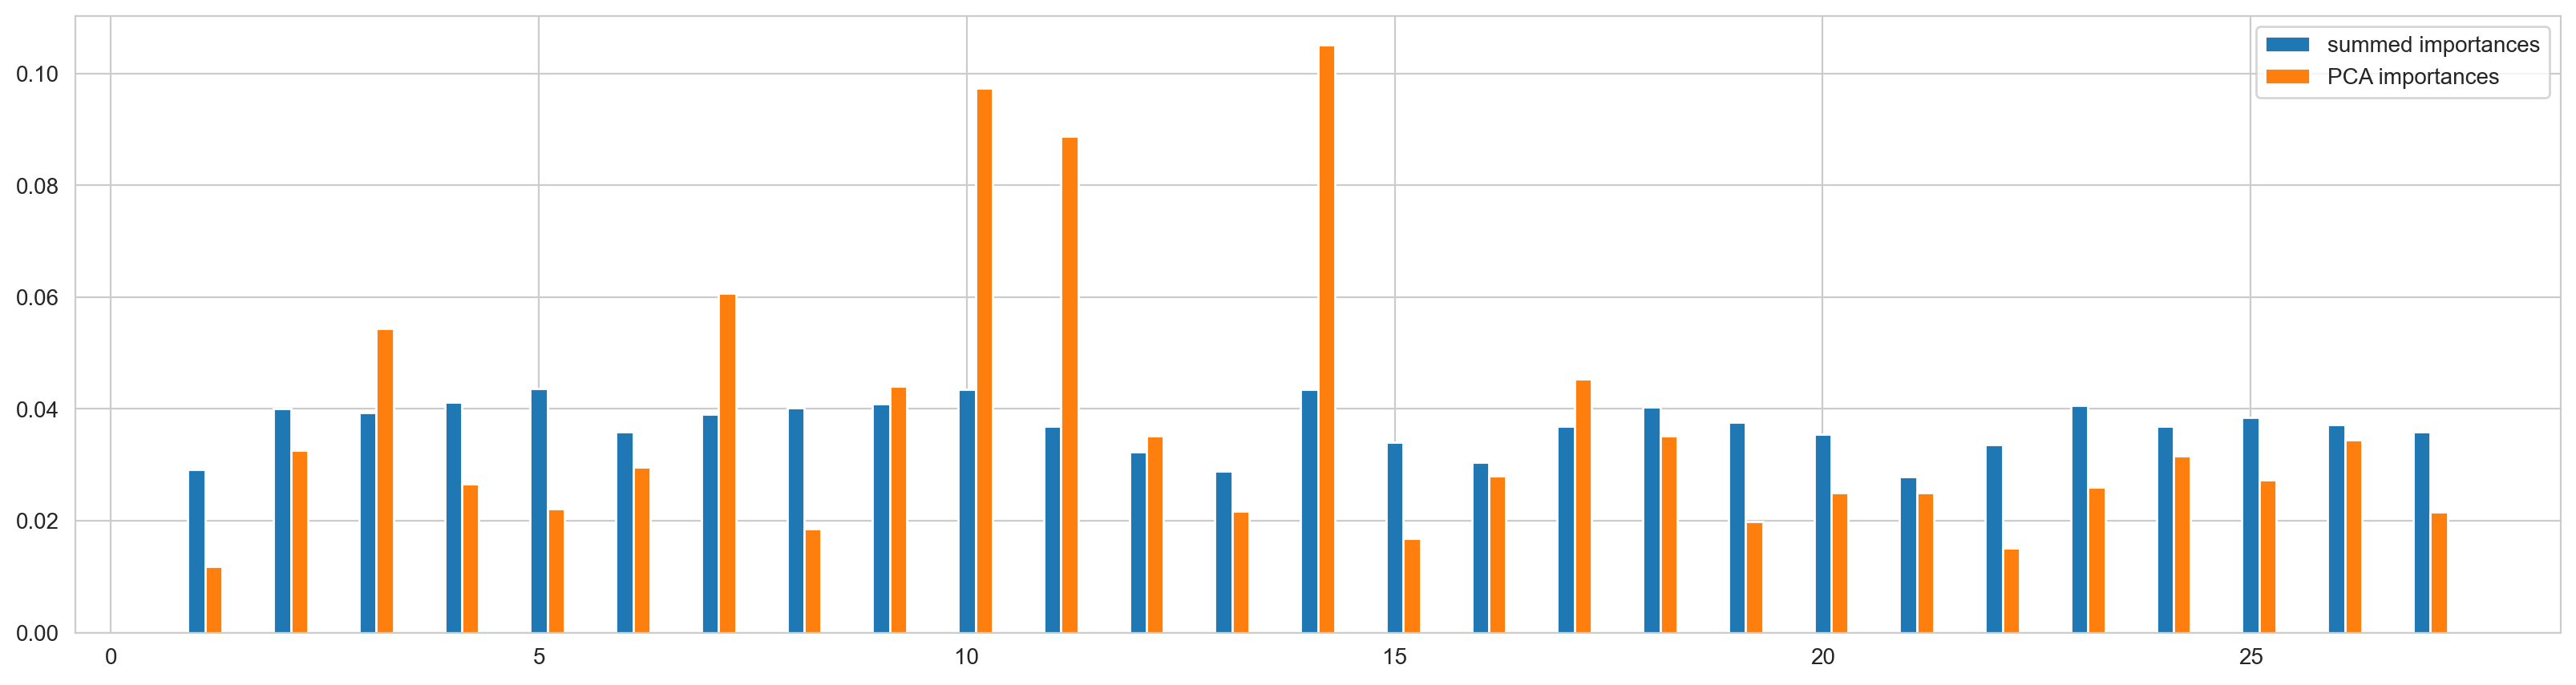

In [54]:
x_bar = np.arange(1, X.shape[-1]+1)
width = .2
plt.figure(dpi=200, figsize=(20,5))
plt.bar(x_bar, to_distribution(loadings_to_importance(calc_loadings(X, pca.transform(X)))), width=width)
plt.bar(x_bar+width, to_distribution(summed_importances), width=width)
plt.legend(["summed importances", "PCA importances"])

In [55]:
accuracies_filtered_PCA_BS = []
X_filtered = np.copy(X)

for i in trange(0, X.shape[-1]):
	accuracies_filtered_PCA_BS.append([
		(cross_val_score(random_forest, X_filtered, y, cv=N_CV, n_jobs=-1).mean()*100).round(2),
		(cross_val_score(logistic_regression, X_filtered, y, cv=N_CV, n_jobs=-1).mean()*100).round(2),
		(cross_val_score(gradient_boosting, X_filtered, y, cv=N_CV, n_jobs=-1).mean()*100).round(2),
		(cross_val_score(svm, X_filtered, y, cv=N_CV, n_jobs=-1).mean()*100).round(2),
	])
	pca = PCA()
	pca.fit(X_filtered)
	loadings = calc_loadings(X_filtered, pca.transform(X_filtered))
	importances = loadings_to_importance(loadings)

	X_filtered = X_filtered[:, np.argsort(to_distribution(importances))[::-1][:-1]]

100%|██████████| 27/27 [00:04<00:00,  6.18it/s]


In [56]:
accuracies_filtered_PCA = []
X_filtered = np.copy(X)
pca = PCA()
pca.fit(X_filtered)
loadings = calc_loadings(X_filtered, pca.transform(X_filtered))
importances = loadings_to_importance(loadings)

for i in trange(0, X.shape[-1]):
	accuracies_filtered_PCA.append([
		(cross_val_score(random_forest, X_filtered, y, cv=N_CV, n_jobs=-1).mean()*100).round(2),
		(cross_val_score(logistic_regression, X_filtered, y, cv=N_CV, n_jobs=-1).mean()*100).round(2),
		(cross_val_score(gradient_boosting, X_filtered, y, cv=N_CV, n_jobs=-1).mean()*100).round(2),
		(cross_val_score(svm, X_filtered, y, cv=N_CV, n_jobs=-1).mean()*100).round(2),
	])

	X_filtered = X[:, np.argsort(to_distribution(importances))[::-1][:-(i+1)]]

100%|██████████| 27/27 [00:03<00:00,  7.91it/s]


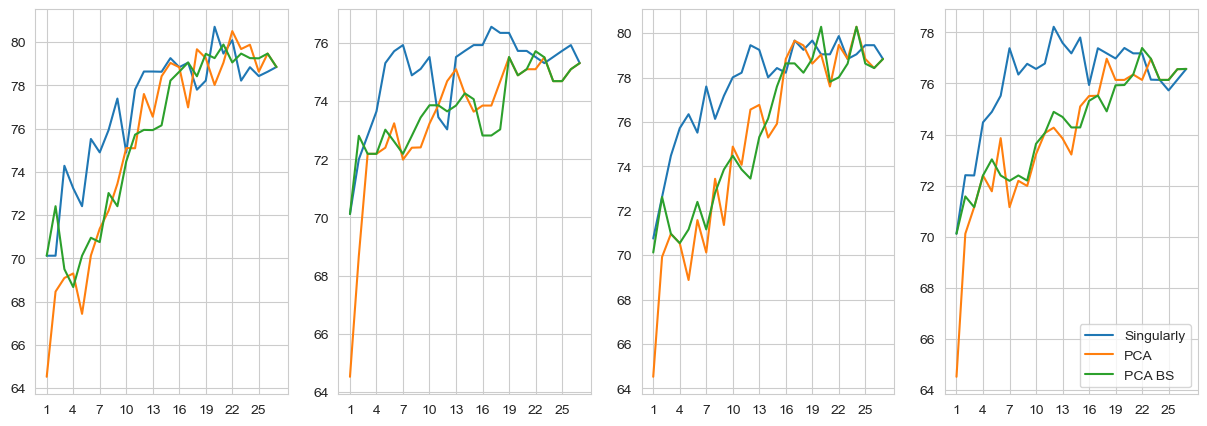

In [57]:
accuracies_filtered_singularly = np.array(accuracies_filtered_singularly)
accuracies_filtered_PCA_BS = np.array(accuracies_filtered_PCA_BS)
accuracies_filtered_PCA = np.array(accuracies_filtered_PCA)

_, axs = plt.subplots(1, 4, figsize=(15,5))
for i in range(4):
	axs[i].plot(np.arange(1, X.shape[-1]+1), accuracies_filtered_singularly[:,i][::-1])
	axs[i].plot(np.arange(1, X.shape[-1]+1), accuracies_filtered_PCA[:,i][::-1])
	axs[i].plot(np.arange(1, X.shape[-1]+1), accuracies_filtered_PCA_BS[:,i][::-1])
	axs[i].set_xticks(np.arange(1, X.shape[-1], 3))
plt.legend(["Singularly", "PCA", "PCA BS"])

### Kernel PCA

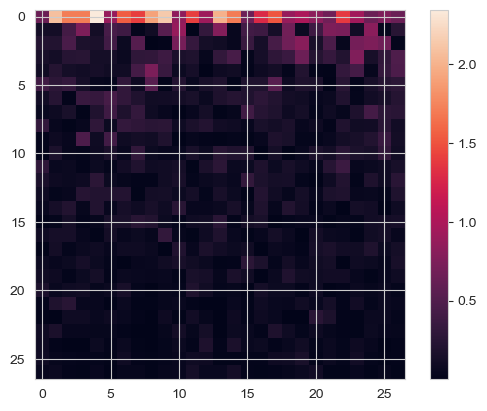

In [58]:
# KernelPCA without limits in number of components or explained variance
kernelpca = KernelPCA()
# Fitting on all the data
kernelpca.fit(X)
plt.imshow(np.abs(calc_loadings(X, kernelpca.transform(X))))
plt.colorbar()

In [59]:
accuracies_filtered_KPCA = []
X_filtered = np.copy(X)

for i in trange(0, X.shape[-1]):
	accuracies_filtered_KPCA.append([
		(cross_val_score(random_forest, X_filtered, y, cv=N_CV, n_jobs=-1).mean()*100).round(2),
		(cross_val_score(logistic_regression, X_filtered, y, cv=N_CV, n_jobs=-1).mean()*100).round(2),
		(cross_val_score(gradient_boosting, X_filtered, y, cv=N_CV, n_jobs=-1).mean()*100).round(2),
		(cross_val_score(svm, X_filtered, y, cv=N_CV, n_jobs=-1).mean()*100).round(2),
	])
	kpca = KernelPCA(kernel="cosine")
	kpca.fit(X_filtered)
	loadings = calc_loadings(X_filtered, kpca.transform(X_filtered))
	importances = loadings_to_importance(loadings)

	X_filtered = X_filtered[:, np.argsort(to_distribution(importances))[::-1][:-1]]

100%|██████████| 27/27 [01:17<00:00,  2.87s/it]


In [60]:
accuracies_filtered_KPCA_honest = []
X_filtered = np.copy(X)

for i in trange(0, X.shape[-1]):
	accuracies_filtered_KPCA_honest.append([
		(cross_val_score(random_forest, X_filtered, y, cv=N_CV, n_jobs=-1).mean()*100).round(2),
		(cross_val_score(logistic_regression, X_filtered, y, cv=N_CV, n_jobs=-1).mean()*100).round(2),
		(cross_val_score(gradient_boosting, X_filtered, y, cv=N_CV, n_jobs=-1).mean()*100).round(2),
		(cross_val_score(svm, X_filtered, y, cv=N_CV, n_jobs=-1).mean()*100).round(2),
	])
	kpca = KernelPCA(kernel="cosine")
	kpca.fit(X_filtered[y==1])
	loadings = calc_loadings(X_filtered[y==1], kpca.transform(X_filtered[y==1]))
	importances = loadings_to_importance(loadings)

	X_filtered = X_filtered[:, np.argsort(to_distribution(importances))[::-1][:-1]]

100%|██████████| 27/27 [00:36<00:00,  1.35s/it]


TypeError: list indices must be integers or slices, not tuple

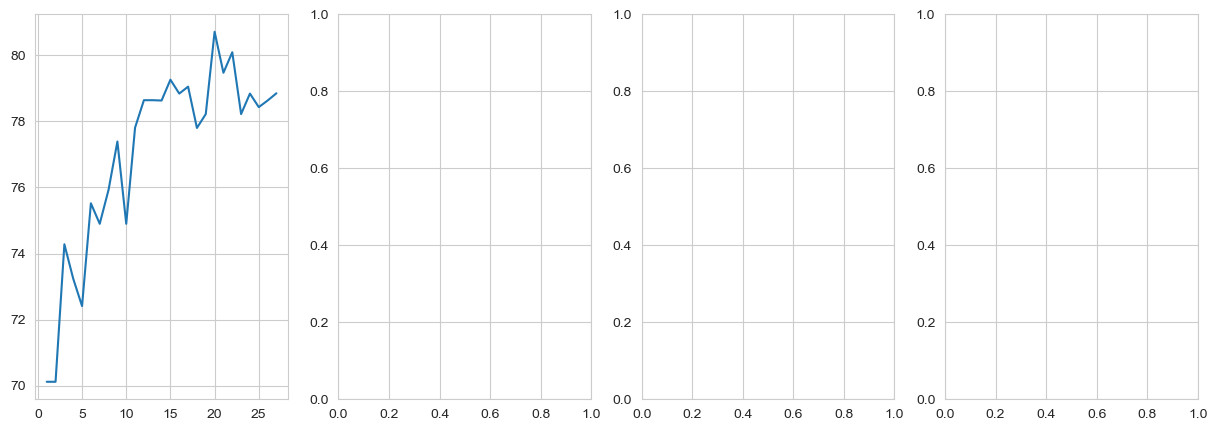

In [61]:
accuracies_filtered_KPCA_honest = np.array(accuracies_filtered_KPCA_honest)

_, axs = plt.subplots(1, 4, figsize=(15,5))
for i in range(4):
	axs[i].plot(np.arange(1, X.shape[-1]+1), accuracies_filtered_singularly[:,i][::-1])
	axs[i].plot(np.arange(1, X.shape[-1]+1), accuracies_filtered_KPCA[:,i][::-1])
	axs[i].plot(np.arange(1, X.shape[-1]+1), accuracies_filtered_KPCA_honest[:,i][::-1])
	axs[i].set_xticks(np.arange(1, X.shape[-1], 3))
plt.legend(["Singularly", "KPCA", "KPCA honest only"])

### Sparse PCA

In [ ]:
# SparsePCA without limits in number of components or explained variance
sparsepca = SparsePCA()
# Fitting on all the data
sparsepca.fit(X)
plt.imshow(np.abs(calc_loadings(X, sparsepca.transform(X))))
plt.colorbar()

In [ ]:
accuracies_filtered_SparsePCA = []
X_filtered = np.copy(X)

for i in trange(0, X.shape[-1]):
	accuracies_filtered_SparsePCA.append([
		(cross_val_score(random_forest, X_filtered, y, cv=N_CV, n_jobs=-1).mean()*100).round(2),
		(cross_val_score(logistic_regression, X_filtered, y, cv=N_CV, n_jobs=-1).mean()*100).round(2),
		(cross_val_score(gradient_boosting, X_filtered, y, cv=N_CV, n_jobs=-1).mean()*100).round(2),
		(cross_val_score(svm, X_filtered, y, cv=N_CV, n_jobs=-1).mean()*100).round(2),
	])
	sparse_pca = SparsePCA()
	sparse_pca.fit(X_filtered)
	loadings = calc_loadings(X_filtered, sparse_pca.transform(X_filtered))
	importances = loadings_to_importance(loadings)

	X_filtered = X_filtered[:, np.argsort(to_distribution(importances))[::-1][:-1]]

In [ ]:
accuracies_filtered_SparsePCA = np.array(accuracies_filtered_SparsePCA)

_, axs = plt.subplots(1, 4, figsize=(15,5))
for i in range(4):
	axs[i].plot(np.arange(1, X.shape[-1]+1), accuracies_filtered_singularly[:,i][::-1])
	axs[i].plot(np.arange(1, X.shape[-1]+1), accuracies_filtered_KPCA[:,i][::-1])
	axs[i].plot(np.arange(1, X.shape[-1]+1), accuracies_filtered_PCA_BS[:,i][::-1])
	axs[i].plot(np.arange(1, X.shape[-1]+1), accuracies_filtered_SparsePCA[:,i][::-1])
	axs[i].set_xticks(np.arange(1, X.shape[-1], 3))
plt.legend(["Singularly", "KPCA", "PCA BS", "SparsePCA"])

### Truncated SVD

In [ ]:
# TruncatedSVD without limits in number of components or explained variance
truncatedsvd = TruncatedSVD(n_components = X.shape[1])
# Fitting on all the data
truncatedsvd.fit(X)
plt.imshow(np.abs(calc_loadings(X, truncatedsvd.transform(X))))
plt.colorbar()

In [ ]:
accuracies_filtered_trunc_SVD = []
X_filtered = np.copy(X)

for i in trange(0, X.shape[-1]-1):
	accuracies_filtered_trunc_SVD.append([
		(cross_val_score(random_forest, X_filtered, y, cv=N_CV, n_jobs=-1).mean()*100).round(2),
		(cross_val_score(logistic_regression, X_filtered, y, cv=N_CV, n_jobs=-1).mean()*100).round(2),
		(cross_val_score(gradient_boosting, X_filtered, y, cv=N_CV, n_jobs=-1).mean()*100).round(2),
		(cross_val_score(svm, X_filtered, y, cv=N_CV, n_jobs=-1).mean()*100).round(2),
	])
	truncated_svd = TruncatedSVD()
	truncated_svd.fit(X_filtered)
	loadings = calc_loadings(X_filtered, truncated_svd.transform(X_filtered))
	importances = loadings_to_importance(loadings)

	X_filtered = X_filtered[:, np.argsort(to_distribution(importances))[::-1][:-1]]

In [ ]:
accuracies_filtered_trunc_SVD = np.array(accuracies_filtered_trunc_SVD)

_, axs = plt.subplots(1, 4, figsize=(15,5))
for i in range(4):
	axs[i].plot(np.arange(1, X.shape[-1]+1), accuracies_filtered_singularly[:,i][::-1])
	axs[i].plot(np.arange(1, X.shape[-1]+1), accuracies_filtered_KPCA[:,i][::-1])
	axs[i].plot(np.arange(1, X.shape[-1]+1), accuracies_filtered_PCA_BS[:,i][::-1])
	axs[i].plot(np.arange(1, X.shape[-1]+1), accuracies_filtered_SparsePCA[:,i][::-1])
	axs[i].plot(np.arange(2, X.shape[-1]+1), accuracies_filtered_trunc_SVD[:,i][::-1])
	axs[i].set_xticks(np.arange(1, X.shape[-1], 3))
plt.legend(["Singularly", "KPCA", "PCA BS", "SparsePCA", "TruncatedSVD"])

### Factor Analysis

In [ ]:
# FastICA without limits in number of components or explained variance
factor = FactorAnalysis()
# Fitting on all the data
factor.fit(X)
plt.imshow(np.abs(calc_loadings(X, factor.transform(X))))
plt.colorbar()

In [ ]:
accuracies_filtered_factor_analysis= []
X_filtered = np.copy(X)

for i in trange(0, X.shape[-1]):
	accuracies_filtered_factor_analysis.append([
		(cross_val_score(random_forest, X_filtered, y, cv=N_CV, n_jobs=-1).mean()*100).round(2),
		(cross_val_score(logistic_regression, X_filtered, y, cv=N_CV, n_jobs=-1).mean()*100).round(2),
		(cross_val_score(gradient_boosting, X_filtered, y, cv=N_CV, n_jobs=-1).mean()*100).round(2),
		(cross_val_score(svm, X_filtered, y, cv=N_CV, n_jobs=-1).mean()*100).round(2),
	])
	factor_analysis = FactorAnalysis()
	factor_analysis.fit(X_filtered)
	loadings = calc_loadings(X_filtered, factor_analysis.transform(X_filtered))
	importances = loadings_to_importance(loadings)

	X_filtered = X_filtered[:, np.argsort(to_distribution(importances))[::-1][:-1]]

In [ ]:
accuracies_filtered_factor_analysis = np.array(accuracies_filtered_factor_analysis)

_, axs = plt.subplots(1, 4, figsize=(15,5))
for i in range(4):
	axs[i].plot(np.arange(1, X.shape[-1]+1), accuracies_filtered_singularly[:,i][::-1])
	axs[i].plot(np.arange(1, X.shape[-1]+1), accuracies_filtered_KPCA[:,i][::-1])
	axs[i].plot(np.arange(1, X.shape[-1]+1), accuracies_filtered_PCA_BS[:,i][::-1])
	axs[i].plot(np.arange(1, X.shape[-1]+1), accuracies_filtered_SparsePCA[:,i][::-1])
	axs[i].plot(np.arange(2, X.shape[-1]+1), accuracies_filtered_trunc_SVD[:,i][::-1])
	axs[i].plot(np.arange(1, X.shape[-1]+1), accuracies_filtered_factor_analysis[:,i][::-1])
	axs[i].set_xticks(np.arange(1, X.shape[-1], 3))
plt.legend(["Singularly", "KPCA", "PCA BS", "SparsePCA", "TruncatedSVD", "Factor Analysis"])

### Relief

In [ ]:
from skrebate import ReliefF

In [ ]:
relief = ReliefF(n_neighbors=5).fit(X,y)

In [ ]:
random_forest = RandomForestClassifier(random_state=0).fit(X,y)
logistic_regression = LogisticRegression(random_state=0).fit(X,y)
gradient_boosting = GradientBoostingClassifier(random_state=0).fit(X,y)
svm = SVC(kernel = "linear", random_state=0).fit(X,y)

In [ ]:
summed_importances=np.sum([
	to_distribution(random_forest.feature_importances_),
	to_distribution(logistic_regression.coef_.squeeze()),
	to_distribution(gradient_boosting.feature_importances_),
	to_distribution( svm.coef_.squeeze())
], axis=0)

In [ ]:
x_bar = np.arange(1, X.shape[-1]+1)
width = .2
plt.figure(dpi=200, figsize=(20,5))
plt.bar(x_bar, to_distribution(relief.feature_importances_), width=width)
plt.bar(x_bar+width, to_distribution(summed_importances), width=width)
plt.legend(["summed importances", "Relief importances"])

In [ ]:
accuracies_with_relief_selection= []
X_filtered = np.copy(X)
for i in trange(0, X.shape[-1]):
	accuracies_with_relief_selection.append([
		(cross_val_score(random_forest, X_filtered, y, cv=N_CV, n_jobs=-1).mean()*100).round(2),
		(cross_val_score(logistic_regression, X_filtered, y, cv=N_CV, n_jobs=-1).mean()*100).round(2),
		(cross_val_score(gradient_boosting, X_filtered, y, cv=N_CV, n_jobs=-1).mean()*100).round(2),
		(cross_val_score(svm, X_filtered, y, cv=N_CV, n_jobs=-1).mean()*100).round(2),
	])

	relief = ReliefF(n_neighbors=5).fit(X_filtered,y)
	relief_feature_importance=to_distribution(relief.feature_importances_)
	X_filtered= X_filtered[:, np.argsort(relief_feature_importance)[::-1][:-1]]

In [ ]:
_, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].set_title("Individual feature selection")
axs[0].plot(np.arange(1, X.shape[-1]+1), accuracies_filtered_singularly[::-1])
axs[0].set_xticks(np.arange(1, X.shape[-1]+1, 3))
axs[0].legend(["Random forest", "Logistic regression", "Gradient boosting", "SVM"])
axs[0].set_xlabel("Number of top feature considered in the training")
axs[0].set_ylabel("Accuracy")

axs[1].set_title("Relief feature selection")
axs[1].plot(np.arange(1, X.shape[-1]+1), accuracies_with_relief_selection[::-1])
axs[1].set_xticks(np.arange(1, X.shape[-1]+1, 3))
axs[1].legend(["Random forest", "Logistic regression", "Gradient boosting", "SVM"])
axs[1].set_xlabel("Number of top feature considered in the training")
axs[1].set_ylabel("Accuracy")

In [ ]:
accuracies_filtered_singularly = np.array(accuracies_filtered_singularly)
accuracies_with_relief_selection = np.array(accuracies_with_relief_selection)

_, axs = plt.subplots(1, 4, figsize=(15,5))
for i in range(4):
	axs[i].plot(np.arange(1, X.shape[-1]+1), accuracies_filtered_singularly[:,i][::-1])
	axs[i].plot(np.arange(1, X.shape[-1]+1), accuracies_with_relief_selection[:,i][::-1])
	axs[i].set_xticks(np.arange(1, X.shape[-1]+1, 3))
plt.legend(["Singularly", "Relief"])

In [ ]:
relief_top_20_features = np.argsort(to_distribution(relief.feature_importances_))[::-1][:int(X.shape[-1] * .2)]

print(f"""
Accuracies:
Random Forest: {(accuracies_with_relief_selection[-int(len(accuracies_with_relief_selection) * .2)][0]).round(2)}%
Logistic Regression: {(accuracies_with_relief_selection[-int(len(accuracies_with_relief_selection) * .2)][1]).round(2)}%
Gradient Boosting: {(accuracies_with_relief_selection[-int(len(accuracies_with_relief_selection) * .2)][2]).round(2)}%
SVC: {(accuracies_with_relief_selection[-int(len(accuracies_with_relief_selection) * .2)][3]).round(2)}%
""")